# Five Levels  of Difficulty - Bayesian Guassian Random Walk with PyMC3 and Theano

This is a walkthrough of Luis Roque's article of the same name.

https://towardsdatascience.com/5-levels-of-difficulty-bayesian-gaussian-random-walk-with-pymc3-and-theano-34343911c7d2

## Import

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import math
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3 as pm
import theano
import theano.tensor as tt
import pandas as pd
import seaborn as sns
import warnings
from pymc3.distributions import distribution
from pymc3.distributions.continuous import Flat, Normal
from decimal import Decimal
from datetime import datetime, timedelta
from collections import OrderedDict

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')


You can find the C code in this temporary file: /var/folders/cy/6893p1j96wn6qcc7yr03xnrh0000gp/T/theano_compilation_error_ewyxh33b


AttributeError: partially initialized module 'theano' has no attribute 'gof' (most likely due to a circular import)

## Model

### Definition

$$y_t = \mu_t + \epsilon_t, \: \: \: \epsilon_t \sim NID\left(0,\sigma_\epsilon^2 \right)$$

$$ \mu_{t+1} = \mu_t + \xi_t, \: \: \: \xi_t \sim NID\left(0, \sigma_\xi^2 \right)$$

wherein $y_t$ is observed and $\mu_t$ is unobserved. The first equation is the *measurement equation* and the second is the *state equation*. Standard HMM stuff.

### Define Random Walk

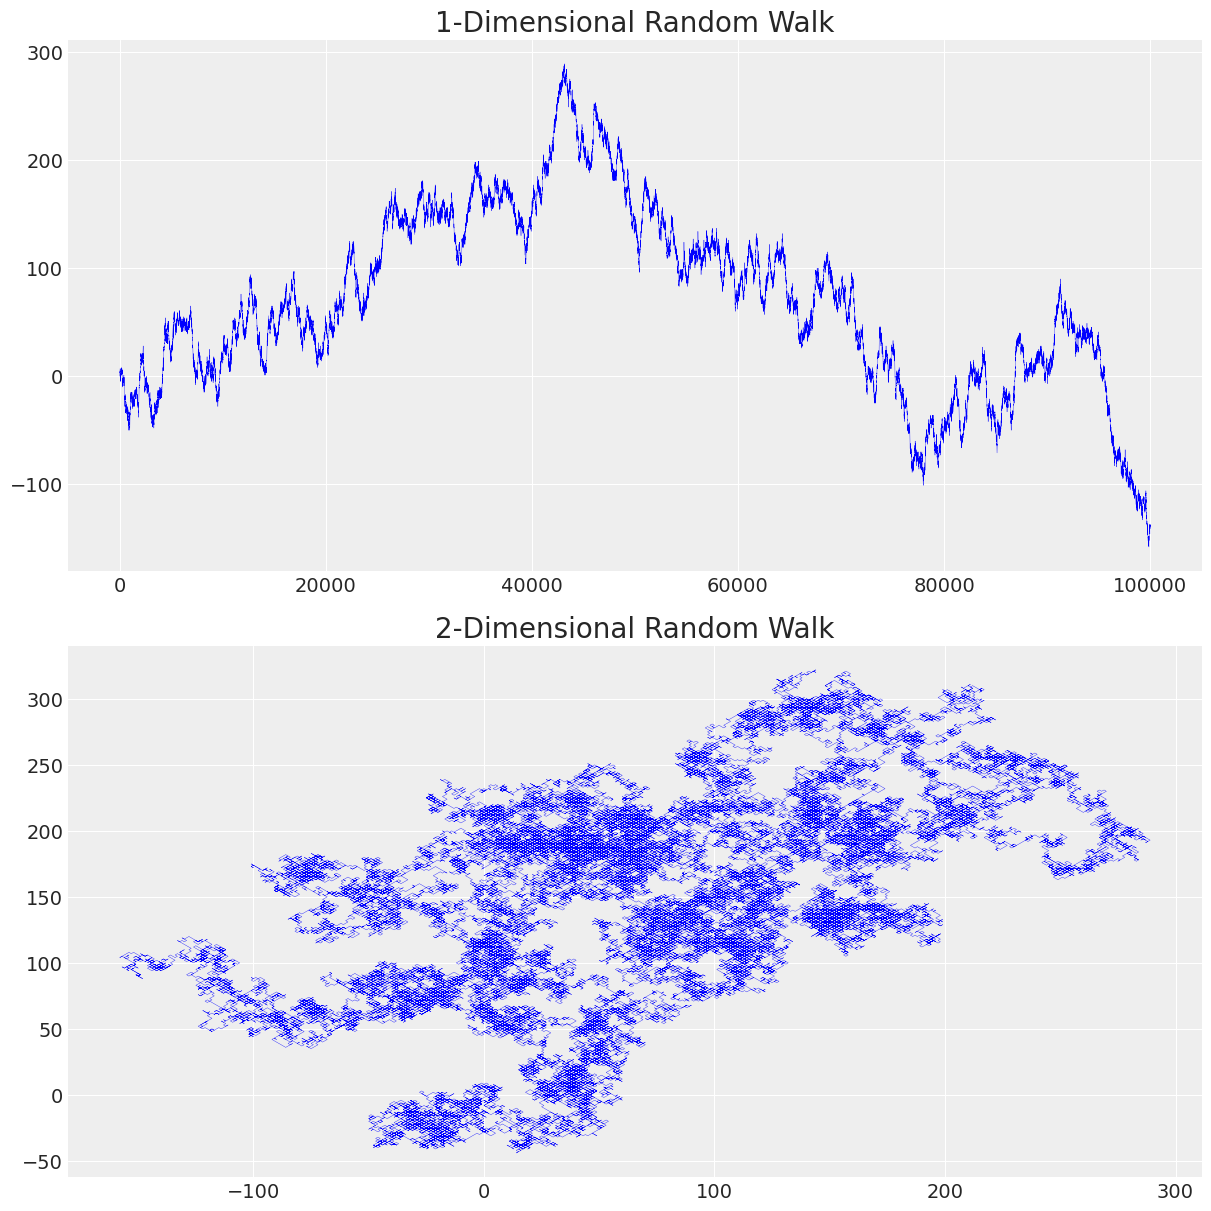

In [15]:
n_steps = 100000
random_walk = np.zeros((n_steps, 2))
origin = np.zeros((1,2))
steps = np.random.choice(a=[-1,1], size=(n_steps,2))
random_walk = np.concatenate([origin, steps]).cumsum(0)

_, ax = plt.subplots(2, 1, figsize=(12,12), constrained_layout = True)

ax[0].plot(random_walk[:,0], c='b', alpha=1, lw=0.25, ls='-')
ax[0].set_title('1-Dimensional Random Walk', fontsize=20)
ax[1].plot(random_walk[:,0], random_walk[:,1], c='b', alpha=1, lw=0.25, ls='-')
ax[1].set_title('2-Dimensional Random Walk', fontsize=20);

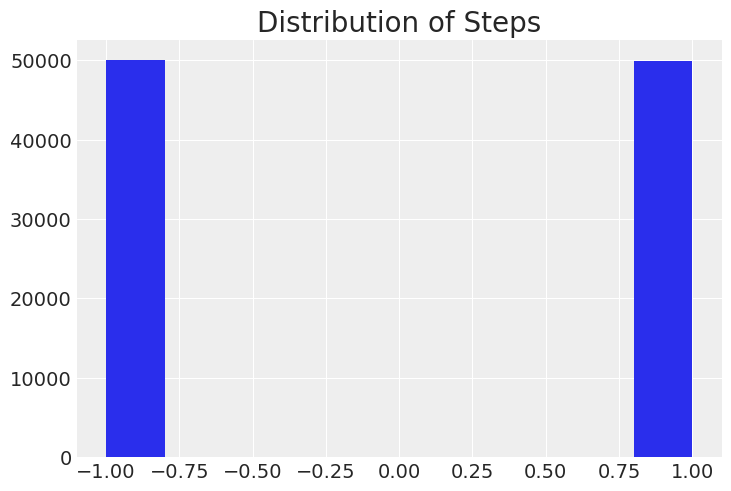

In [16]:
## Distribution of steps
plt.hist(steps[:,0])
plt.title('Distribution of Steps', fontsize=20);

Each step is an independent Bernoulli trial, making the path walked follow a Binomial Distribution:

$$X \sim B(n,p)$$

$$P(x;n,p) = {n \choose x}p^x(1-p)^{n-x}$$

Where $n \in \mathbb{N}$ and $p \in [0,1]$ (because it is a probability).

With p = 0.5 (like a coin flip), the path walked follows this distribution:

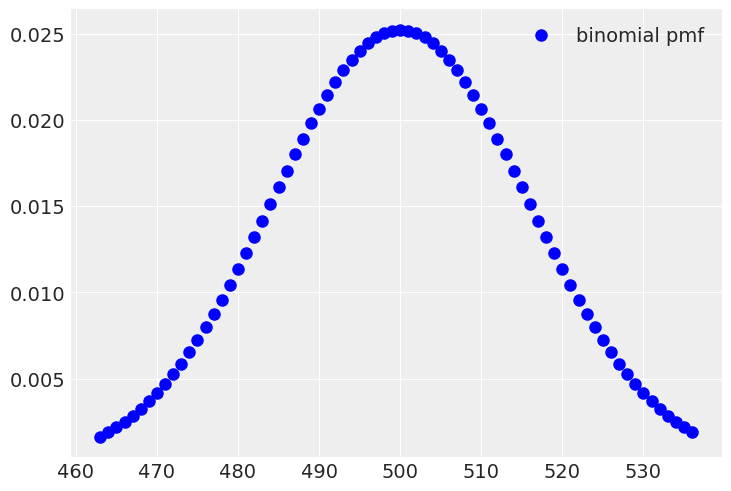

In [4]:
fig, ax = plt.subplots(1,1)
p = 0.5
X = np.arange(stats.binom.ppf(0.01, n_steps/100, p),
              stats.binom.ppf(0.99, n_steps/100, p))
ax.plot(X, stats.binom.pmf(X, n_steps/100, 0.5), 'bo', ms=8, label='binomial pmf')
ax.legend();

The cdf of the binomial can be expressed as:

$$P(X\le x) = \sum_{i=0}^{|x|} {n \choose i}p^i (1-p)^{n-i}$$

Which is really just finding the value of the pmf at each value, $P(X = x)$, and summing them up. 

In [5]:
## show that the sum of the first half is about 0.5
print(np.sum([stats.binom.pmf(i, n_steps, 0.5) for i in range(int(n_steps/2))]))
print(stats.binom.cdf(n_steps/2, n_steps, 0.5))

0.49873843682199015
0.5012615631976961


As $n \to \infty$, $Binom(n,p)$ converges in distribution $N\left(\mu = np, \sigma^2 = np(1-p)\right)$.

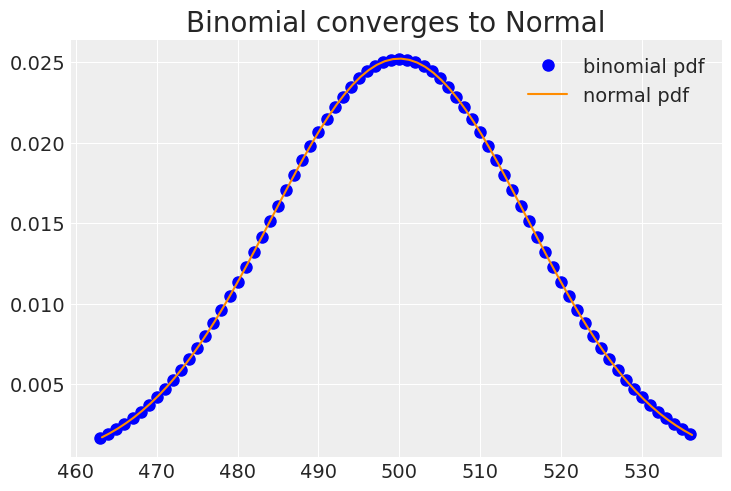

In [6]:
mu = 500
sigma = 250

fig, ax = plt.subplots(1,1)
p=0.5

x = np.arange(stats.binom.ppf(0.01, n_steps/100, p),
              stats.binom.ppf(0.99, n_steps/100, p))
ax.plot(x, stats.binom.pmf(x, n_steps/100, 0.5), 'bo', ms=8, label='binomial pdf')

x = np.arange(stats.norm.ppf(0.01, n_steps/100*p, np.sqrt(n_steps/100 * p * (1-p))),
              stats.norm.ppf(0.99, n_steps/100*p, np.sqrt(n_steps/100 * p * (1-p))))
ax.plot(x, stats.norm.pdf(x, n_steps/100 * p, np.sqrt(n_steps/100 * p * (1-p))), color='darkorange', ms=8, label='normal pdf')
ax.plot()
ax.set_title('Binomial converges to Normal', fontsize=20)
ax.legend();


### Gaussian (Normal) Random Walk

We are going to make another random walk, but instead of independent Bernoulli trials resulting in a Binomial distribution, we are going to draw direction and distance from a Standard Gaussian distribution.

$$N(0, 1)$$

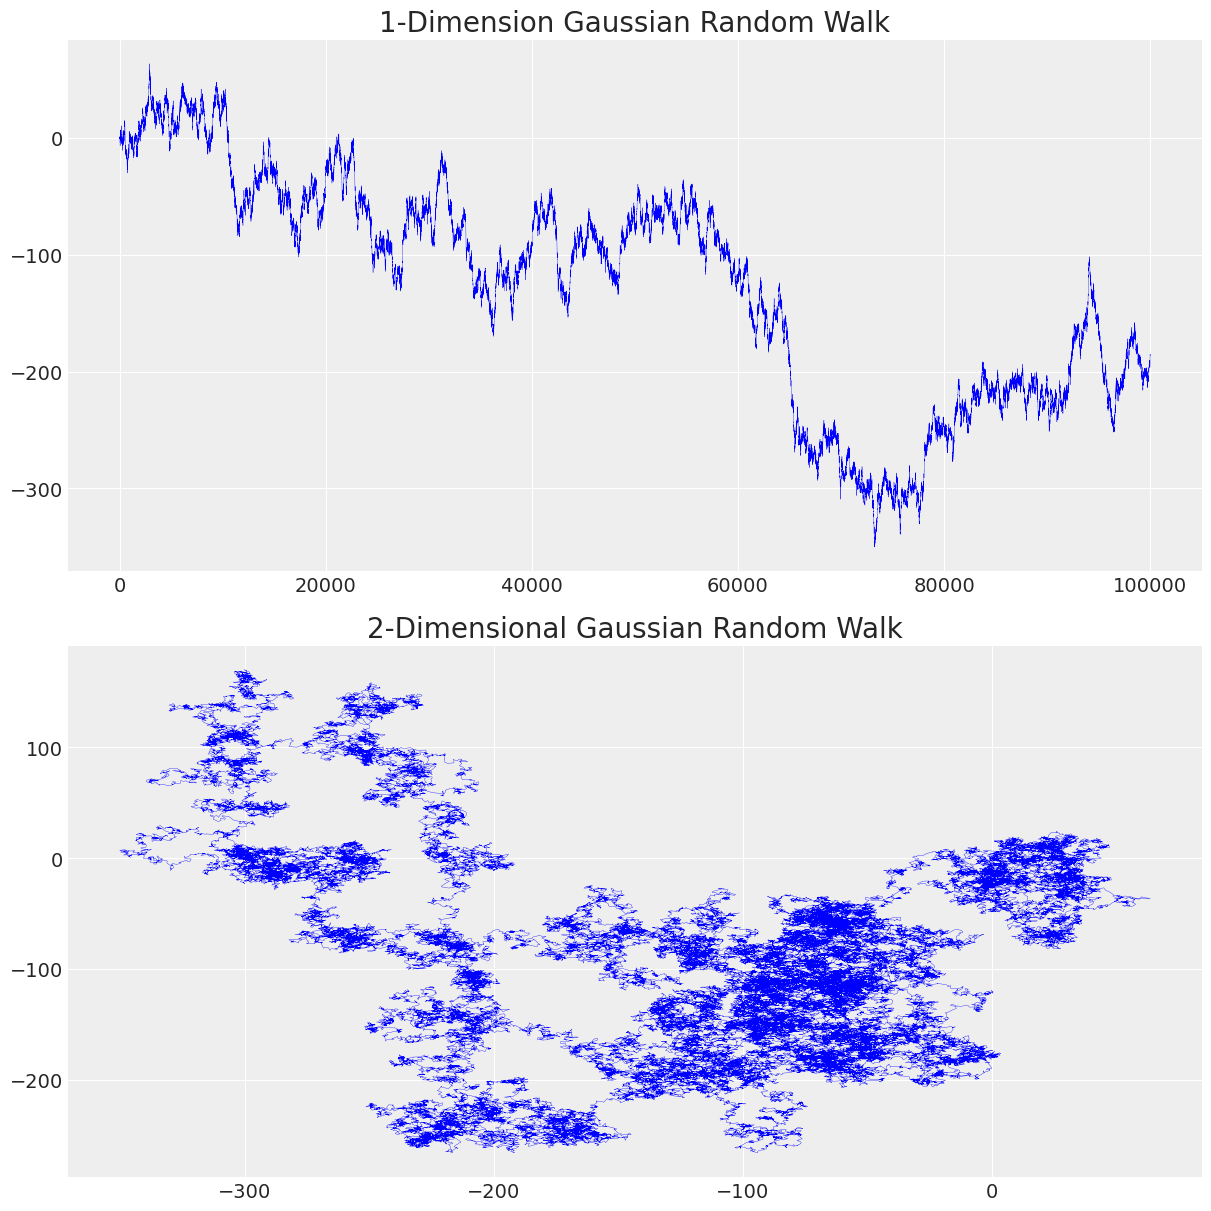

In [7]:
n_steps= 100000
random_walk = np.zeros((n_steps,2))
origin = np.zeros((1,2))
steps = np.random.normal(loc=0, scale=1, size=(n_steps, 2))
random_walk = np.concatenate([origin, steps]).cumsum(0)

_, ax = plt.subplots(2,1, figsize=(12,12), constrained_layout=True)

ax[0].plot(random_walk[:,0], c='blue', alpha=1, lw=0.25, ls='-')
ax[0].set_title('1-Dimension Gaussian Random Walk', fontsize=20)
ax[1].plot(random_walk[:,0], random_walk[:,1], c='blue', alpha=1, lw=0.25, ls='-')
ax[1].set_title('2-Dimensional Gaussian Random Walk', fontsize=20);

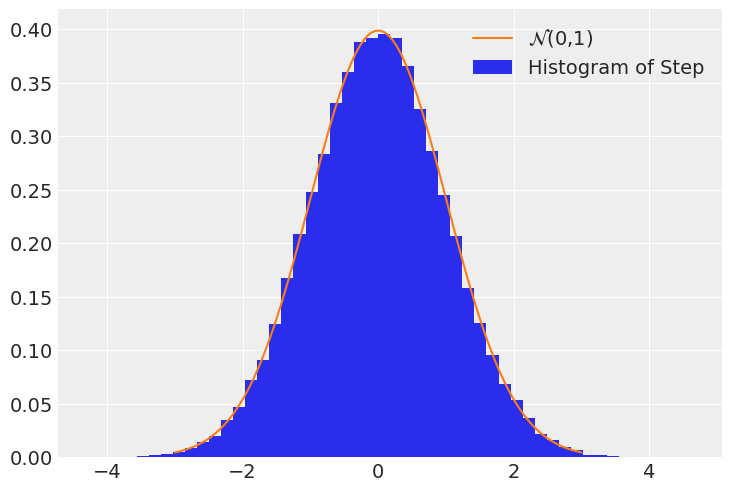

In [8]:
## Check the distribution of steps!
plt.hist(steps[:,0], bins=50, density=True, label='Histogram of Step')
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu-3*sigma, mu+3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='$\mathcal{N}$(0,1)')
plt.legend();

### Stationarity

A random walk is not stationary; the variance changes over time. Let's see why!

Let $Y_t$ be the position of the walker at time $t$, and let $\epsilon_t$ be the change in position from time $t-1$ to $t$. Then, the walk can be defined as:

$$Y_t = Y_0 + \epsilon_1 + \epsilon_2 + ... + \epsilon_t$$

or...

$$Y_t = Y_0 + \sum_{i=1}^t \epsilon_i$$

The variance of this is:

\begin{align*}
    Var(Y_t) &= Var(Y_0 + \sum_{i=1}^t \epsilon_i \\
    \\
    &= Var\left( \sum_{i=1}^t \epsilon_t \right) \\
    \\
    &= Var(\epsilon_1 + \epsilon_2 + ... + \epsilon_t) \\
    \\
    &= Var(\epsilon_1) + Var(\epsilon_2) + ... + Var(\epsilon_t) \\
    \\
    &= \sigma_\epsilon^2 + \sigma_\epsilon^2 + ... + \sigma_\epsilon^2 \\
    \\
    &= t\sigma_\epsilon^2
\end{align*}


To see the non-stationarity another way, let's look at the auto-correlation function; it is non-zero for many lags.

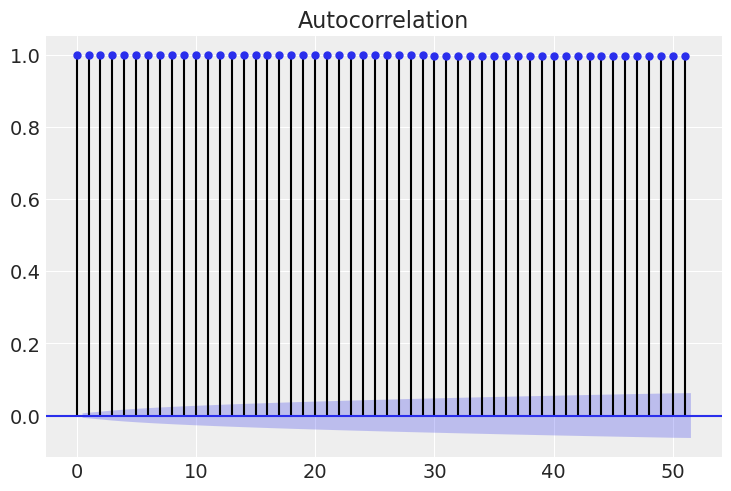

In [9]:
plot_acf(random_walk[:,0]);

Or we could draw a bunch of random walks and see how they spread out over time.

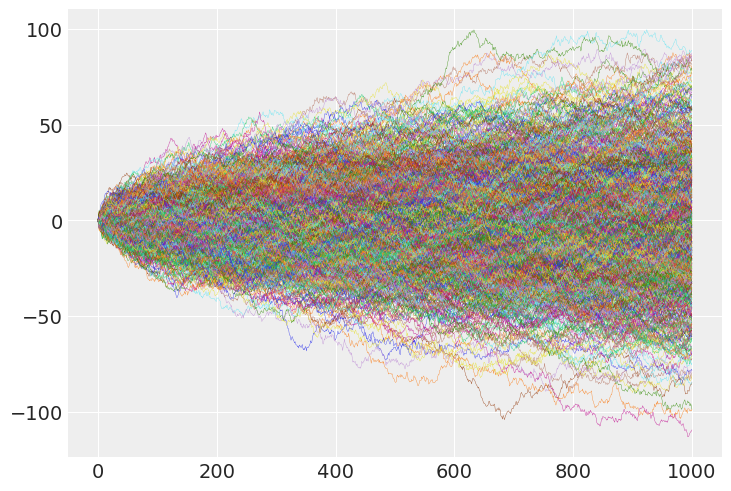

In [10]:
n_steps = 1000
random_walks = []
for i in range(1000):
    origin=np.zeros((1,1))
    steps = np.random.normal(loc=0, scale=1, size=(n_steps,1))
    random_walk = np.concatenate([origin, steps]).cumsum(0)
    plt.plot(random_walk, alpha=1, lw=0.25, ls='-')

## Classical Model

We will create a classical model before trying the Bayesian model.

We will use an Unobserved Components model of the following form:

$$y_t = \mu_t + \gamma_t + c_t + \varepsilon_t$$

Wherein $y_t$ is the observed measurement, $\mu_t$ is the trend component, $\gamma_t$ is the seasonal component, $c_t$ is the cycle component, and $\varepsilon_t$ is the 'irregular' component.

This model will use the Maximum Likelihood Estimator (MLE) for each component.

### Bring in Data

In [11]:
ukdrivers = np.genfromtxt('UKdriversKSI.txt', skip_header=True)

### Construct Model

In [12]:
# Use the log
y = np.log(ukdrivers)
t = np.arange(1, len(y)+1)

model_ll = sm.tsa.UnobservedComponents(y, 'local level')
model_fit = model_ll.fit()
print(model_fit.summary())

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  192
Model:                    local level   Log Likelihood                 123.878
Date:                Mon, 08 Feb 2021   AIC                           -243.755
Time:                        11:35:06   BIC                           -237.251
Sample:                             0   HQIC                          -241.121
                                - 192                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0022      0.001      2.170      0.030       0.000       0.004
sigma2.level         0.0119      0.002      5.926      0.000       0.008       0.016
Ljung-Box (L1) (Q):         

## Bayesian Model

We are going to make 5 Bayesian models, each with increasing complexity. 

1. *Off-the-shelf* implementation of the Gaussian Random Walk class from PyMC3.
2. Tweaks for difficult-to-sample, highly-correlated posterior distributions
3. Lightly manipulated PyMC3 model
4. Custom GRW class
5. Use Theano to implement all the steps, from scratch

#### Notes on PyMC3 and Theano

PyMC3 is built on top of Theano, which is a library built to help people define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays quite efficiently. The Theano library is maintained by the PyMC3 team. Theano and JAX will be the computational backgrounds for PyMC3 for the future.

### *Off-the-shelf* model

In [22]:
with pm.Model() as m1:
    
    # priors
    sigma_eps = pm.HalfNormal('sigma_eps', 1)
    sigma_xi = pm.HalfNormal('sigma_xi', 1)
    
    # adaptive prior
    mu = pm.GaussianRandomWalk('mu', sigma=sigma_xi, shape=len(y))
    
    # likelihood
    level = pm.distributions.continuous.Normal('level', mu=mu, sigma=sigma_eps, observed=y)
    
    trace = pm.sample(2000, target_accept=0.95, init='advi+adapt_diag', tune=3000)
    
pm.traceplot(trace, var_names=['~mu'])

INFO (theano.gof.compilelock): Refreshing lock /Users/johnrizcallah/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.3-64/lock_dir/lock



You can find the C code in this temporary file: /var/folders/cy/6893p1j96wn6qcc7yr03xnrh0000gp/T/theano_compilation_error_39nxhel5


Exception: ('Compilation failed (return status=1): /Users/johnrizcallah/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.3-64/tmps2zjwnkk/mod.cpp:3:10: fatal error: \'theano_mod_helper.h\' file not found. #include "theano_mod_helper.h".          ^~~~~~~~~~~~~~~~~~~~~. 1 error generated.. ', '[Elemwise{mul,no_inplace}(TensorConstant{3.141592653589793}, TensorConstant{1.0})]')